<a href="https://colab.research.google.com/github/NarciSource/Aivle--MiniProject-6-2/blob/main/%EC%B0%A8%EB%9F%89_%ED%8C%8C%EC%86%90%EC%97%AC%EB%B6%80_%EB%B6%84%EB%A5%98_%EC%97%90%EC%9D%B4%EB%B8%94%EB%9F%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Augmentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리 불러오기

In [ ]:
import zipfile, os, random, shutil, glob, yaml, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

### (3) 데이터 불러오기

#### 1) 데이터 압축 해제

In [ ]:
path = '/content/drive/MyDrive/aivle/mp6_2/input/'
dataset_path = '/content/drive/MyDrive/aivle/mp6_2/dataset/'

In [ ]:
file1 = 'Car_Images.zip'
path + file1

'/content/drive/MyDrive/aivle/mp6_2/input/Car_Images.zip'

In [ ]:
# 압축 해제

data = zipfile.ZipFile(path+file1)

try :
    print('압축을 해제합니다.')
    data.extractall(path)
    print('압축 해제가 완료되었습니다.')
except :
    pass
    print('압축이 이미 해제되었거나 이미 폴더가 존재합니다.')

압축을 해제합니다.
압축 해제가 완료되었습니다.


#### 2) 데이터 조회

In [ ]:
# 폴더별 이미지 데이터 갯수 확인

print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.


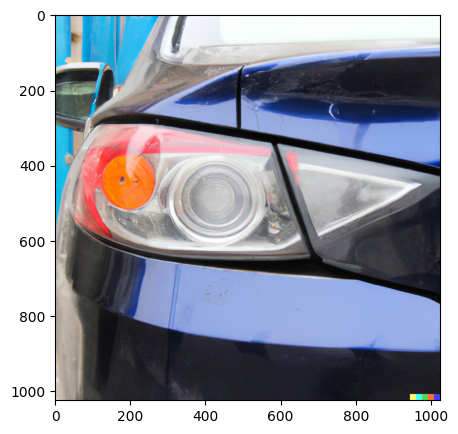

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [ ]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인

rand_n = random.randint( 0, len(glob.glob(path+'normal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'normal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

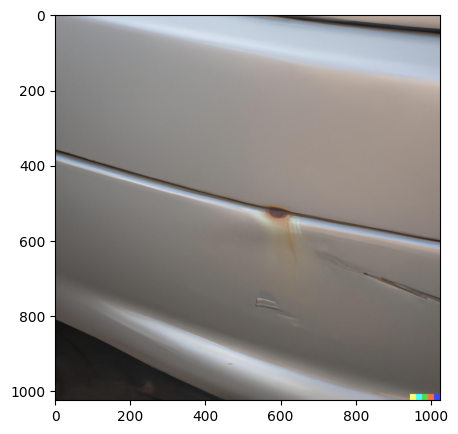

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [ ]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인

rand_n = random.randint( 0, len(glob.glob(path+'abnormal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'abnormal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

## 2.데이터 전처리

### (1) 모델링 I용 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

#### 1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [ ]:
len(glob.glob(path+'abnormal/*')), len(glob.glob(path+'normal/*'))

(303, 302)

In [ ]:
y = [0]*len(glob.glob(path+'normal/*')) + [1]*len(glob.glob(path+'abnormal/*'))
len(y)

605

#### 2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [ ]:
files = glob.glob(path+'normal/*') + glob.glob(path+'abnormal/*')

#### 3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1: 1 로 설정하세요.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
files_train_x, files_test_x, train_y, test_y = train_test_split(files, y, train_size=.8, stratify=y)
files_valid_x, files_test_x, valid_y, test_y = train_test_split(files_test_x, test_y, train_size=.5, stratify=test_y)
(len(files_train_x), len(train_y)), (len(files_valid_x), len(valid_y)), (len(files_test_x), len(test_y))

((484, 484), (60, 60), (61, 61))

In [ ]:
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

#### 4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

In [ ]:
files_to_array = lambda files: np.array([keras.utils.img_to_array(keras.utils.load_img(file, target_size=(280,280,3))) for file in files])

In [ ]:
train_x = files_to_array(files_train_x)
valid_x = files_to_array(files_valid_x)
test_x = files_to_array(files_test_x)

train_x.shape, valid_x.shape, test_x.shape

((484, 280, 280, 3), (60, 280, 280, 3), (61, 280, 280, 3))

### (2) 모델링 II용 전처리

#### 1) 데이터셋 분리를 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 데이터셋을 만들기 위해 각각 폴더를 생성하고, 하위 폴더 normal과 abnormal을 생성합니다.
        * 정상 이미지 저장소
            - project/Car_Images_train/normal/
            - project/Car_Images_val/normal/
            - project/Car_Images_test/normal/
        * 파손 이미지 저장소
            - project/Car_Images_train/abnormal/
            - project/Car_Images_val/abnormal/
            - project/Car_Images_test/abnormal/
---
- 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
    - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [ ]:
!pip install split-folders

#### 2) 각 폴더에 이미지 데이터 복사
- **세부요구사항**
    - 이전 단계에서 생성한 폴더 normal, abnormal 각각에 이미지 파일을 복사합니다.
    - 데이터 스플릿의 비율은 train set : validation set : test set = 8 : 1 : 1 로 설정하세요.

In [ ]:
import splitfolders
splitfolders.ratio(path, output=dataset_path, ratio=(.8,.1,.1), group_prefix=1)

Copying files: 605 files [02:11,  4.59 files/s]


#### 3) Y : 클래스 만들기
- **세부요구사항**
    - Test용 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

#### 4) X : image to array
- **세부요구사항**
    * 모델링 II에서는 ImageDataGenerator를 이용하기 때문에 Test data에 대해서만 np.array 형태로 데이터셋을 만들어야 합니다.
    * 이미지 파일을 불러와 Test data 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

In [ ]:
files_test_normal = glob.glob(dataset_path+"test/normal/*")
files_test_abnormal = glob.glob(dataset_path+"test/abnormal/*")

In [ ]:
test_normal = files_to_array(files_test_normal)
test_abnormal = files_to_array(files_test_abnormal)

test_normal.shape, test_abnormal.shape

((31, 280, 280, 3), (31, 280, 280, 3))

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### 1) 구조 설계

In [ ]:
clear_session()

model = Sequential([
    Input(shape=train_x.shape[1:]),
    Conv2D(filters = 64, kernel_size=(3,3), strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(filters = 32, kernel_size=(3,3), strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='LeakyReLU'),
    Dense(32, activation='LeakyReLU'),
    Dense(2, activation='softmax')
])

model.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 139, 139, 64)      1792      
                                                                 
 average_pooling2d (Average  (None, 69, 69, 64)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 average_pooling2d_1 (Avera  (None, 17, 17, 32)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 9248)              0         
                                                                 
 dense (Dense)               (None, 64)                5

#### 2) 학습

Epoch 1/10000
16/16 [==============================] - 20s 1s/step - loss: 404.5824 - accuracy: 0.5186 - val_loss: 20.9101 - val_accuracy: 0.5000
Epoch 2/10000
16/16 [==============================] - 19s 1s/step - loss: 94.9512 - accuracy: 0.5083 - val_loss: 13.4041 - val_accuracy: 0.5000
Epoch 3/10000
16/16 [==============================] - 21s 1s/step - loss: 17.8523 - accuracy: 0.5248 - val_loss: 6.4430 - val_accuracy: 0.5500
Epoch 4/10000
16/16 [==============================] - 11s 648ms/step - loss: 57.3864 - accuracy: 0.5289 - val_loss: 11.2206 - val_accuracy: 0.5000
Epoch 5/10000
16/16 [==============================] - 11s 708ms/step - loss: 3.4517 - accuracy: 0.6219 - val_loss: 12.1722 - val_accuracy: 0.5333
Epoch 6/10000
16/16 [==============================] - 11s 708ms/step - loss: 89.4884 - accuracy: 0.4690 - val_loss: 5.7161 - val_accuracy: 0.5000
Epoch 7/10000
16/16 [==============================] - 10s 635ms/step - loss: 12.3719 - accuracy: 0.5145 - val_loss: 23.986

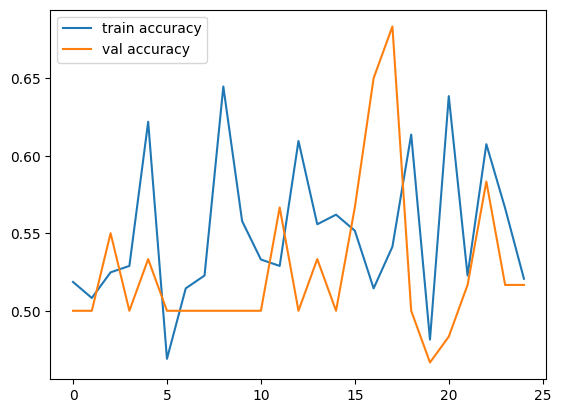

In [ ]:
from sklearn.utils import validation
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(train_x, train_y,
                    epochs=10000,
                    validation_data=(valid_x, valid_y),
                    callbacks=[es])

sns.lineplot(history.history['accuracy'], label='train accuracy')
sns.lineplot(history.history['val_accuracy'], label='val accuracy')
plt.show()

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
pred_y = model.predict(test_x)
pred_y = list(map(np.argmax, pred_y))
classification_report(pred_y, test_y)
accuracy_score(pred_y, test_y)

2/2 [==============================] - 1s 373ms/step


0.5409836065573771

### (2) 모델 2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

#### 1) 구조 설계

In [ ]:
clear_session()

model2 = Sequential([
    Input(shape=train_x.shape[1:]),
    Conv2D(filters = 32, kernel_size=(3,3), activation='LeakyReLU', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(filters = 64, kernel_size=(3,3), activation='LeakyReLU', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='LeakyReLU'),
    Dense(32, activation='LeakyReLU'),
    Dense(2, activation='softmax')
])

model2.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy, metrics=['accuracy'])
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 139, 139, 32)      896       
                                                                 
 average_pooling2d (Average  (None, 69, 69, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 17, 17, 64)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dense (Dense)               (None, 128)               2

#### 2) 학습

Epoch 1/10000
16/16 [==============================] - 12s 718ms/step - loss: 3.2824 - accuracy: 0.5083 - val_loss: 1.4161 - val_accuracy: 0.5500
Epoch 2/10000
16/16 [==============================] - 10s 648ms/step - loss: 35.7515 - accuracy: 0.6157 - val_loss: 11.4002 - val_accuracy: 0.5000
Epoch 3/10000
16/16 [==============================] - 10s 583ms/step - loss: 72.3871 - accuracy: 0.5393 - val_loss: 4.6968 - val_accuracy: 0.5167
Epoch 4/10000
16/16 [==============================] - 11s 712ms/step - loss: 2.3315 - accuracy: 0.6426 - val_loss: 1.5284 - val_accuracy: 0.5167
Epoch 5/10000
16/16 [==============================] - 12s 743ms/step - loss: 38.1691 - accuracy: 0.4690 - val_loss: 49.3208 - val_accuracy: 0.5000
Epoch 6/10000
16/16 [==============================] - 11s 693ms/step - loss: 68.3158 - accuracy: 0.4938 - val_loss: 47.5813 - val_accuracy: 0.4833
Epoch 7/10000
16/16 [==============================] - 11s 652ms/step - loss: 21.1047 - accuracy: 0.5310 - val_loss: 

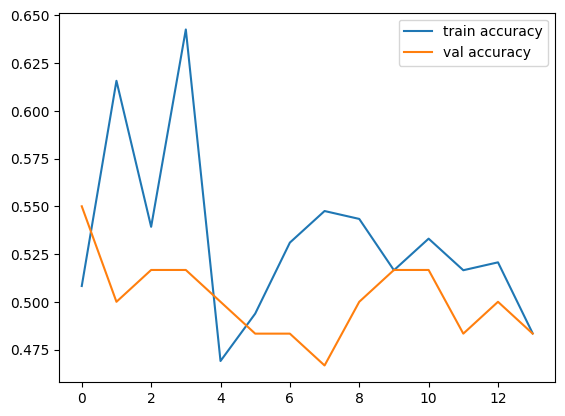

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(train_x, train_y,
          epochs=10000,
          validation_data=(valid_x, valid_y),
          callbacks=[es])

sns.lineplot(history.history['accuracy'], label='train accuracy')
sns.lineplot(history.history['val_accuracy'], label='val accuracy')
plt.show()

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
pred_y = list(map(np.argmax, model.predict(test_x)))
classification_report(pred_y, test_y)
accuracy_score(pred_y, test_y)

2/2 [==============================] - 0s 202ms/step


0.5245901639344263

### (3) 모델 3
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

#### 1) 구조 설계

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation,LeakyReLU

model = Sequential([
    Input(shape=(280, 280, 3)),

    # First convolutional block
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    AvgPool2D(pool_size=(2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    AvgPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    AvgPool2D(pool_size=(2, 2)),

    # Flattening the 3D output to 1D
    Flatten(),

    # Fully connected layer
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 280, 280, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 280, 280, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 280, 280, 32)      0         
                                                                 
 average_pooling2d_2 (Avera  (None, 140, 140, 32)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 140, 140, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 140, 140, 64)     

#### 2) 학습

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_lr=0.001)

model_checkpoint = ModelCheckpoint(filepath="best_model.h5",
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


In [ ]:
# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# List of callbacks
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('start fitting')
# Training the model with callbacks
history = model.fit(
    train_x, train_y,
    epochs=10000000,
    batch_size = 8,
    validation_data=(valid_x, valid_y),
    callbacks=callbacks_list,
)
print('fitting done')

Num GPUs Available:  0
start fitting
Epoch 1/10000000
61/61 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7748
Epoch 1: val_loss improved from inf to 13.04005, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 141s 2s/step - loss: 0.5225 - accuracy: 0.7748 - val_loss: 13.0401 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10000000
61/61 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8099
Epoch 2: val_loss improved from 13.04005 to 3.82120, saving model to best_model.h5
61/61 [==============================] - 134s 2s/step - loss: 0.4316 - accuracy: 0.8099 - val_loss: 3.8212 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10000000
61/61 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8202
Epoch 3: val_loss improved from 3.82120 to 0.85897, saving model to best_model.h5
61/61 [==============================] - 135s 2s/step - loss: 0.4034 - accuracy: 0.8202 - val_loss: 0.8590 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/10000000
61/61 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8182
Epoch 4: val_loss improved from 0.85897 to 0.63646, saving model to best_model.h5
61/61 [================

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


In [ ]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary outputs

# Compute metrics
acc = accuracy_score(test_y, y_pred)
cm = confusion_matrix(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
print(acc)
print(cm)

## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * ImageDatagenerator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

#### 1) ImageDataGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

#### 2) 데이터 경로에서 이미지 불러 올 준비하기
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고,
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                             featurewise_center = True,

                            rotation_range=40,        # Degree range for random rotations
                            width_shift_range=0.2,    # Range for random horizontal shifts
                            height_shift_range=0.2,   # Range for random vertical shifts
                            shear_range=0.2,          # Shear intensity (shear angle in counter-clockwise direction in degrees)
                            zoom_range=0.2,           # Range for random zoom
                            horizontal_flip=True,    # Randomly flip inputs horizontally
                            fill_mode='nearest'      # Points outside boundaries are filled according to mode: 'nearest' or 'constant'

                             )
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/aivle/mp6_2/dataset/train',
                                              shuffle = True,
                                              target_size=(280, 280),
                                              batch_size=30,
                                              class_mode = 'binary',
                                                    classes=['normal', 'abnormal'])


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory('/content/drive/MyDrive/aivle/mp6_2/dataset/val',
                                              shuffle = True,
                                              target_size=(280, 280),
                                              batch_size=30,
                                              class_mode = 'binary',
                                                classes=['normal', 'abnormal'])

Found 483 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


#### 3) 구조 설계

In [ ]:
model2_1 = Sequential([
    Input(shape=train_x.shape[1:]),
    Conv2D(filters = 32, kernel_size=(3,3), activation='LeakyReLU', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),

    Conv2D(filters = 64, kernel_size=(3,3), activation='LeakyReLU', strides=(2,2)),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='LeakyReLU'),
    Dense(32, activation='LeakyReLU'),
    Dense(2, activation='softmax')
])

model2_1.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy, metrics=['accuracy'])

NameError: ignored

#### 4) 학습

In [ ]:
history = model2_1.fit(
    train_generator,
    epochs=100000,
    validation_data = val_generator,
    callbacks = [es],
    verbose=2,
)

In [ ]:
sns.lineplot(history.history['accuracy'], label='train accuracy')
sns.lineplot(history.history['val_accuracy'], label='val accuracy')
plt.show()

#### 5) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
test_x = np.concatenate((test_normal, test_abnormal))
test_y = [0]*len(test_normal) + [1]*len(test_abnormal)
test_x.shape, len(test_y)

((62, 280, 280, 3), 62)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_x, batch_size=30, shuffle=False)

In [ ]:
pred_y = model2_1.predict(test_generator)
pred_y = list(map(np.argmax,pred_y))
classification_report(pred_y, test_y)
accuracy_score(pred_y, test_y)

### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다.
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.


In [ ]:
train_x.shape

(484, 280, 280, 3)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_x.shape[1:])
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                              

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [ ]:
from keras.src.layers.convolutional.conv2d import activations
il = base_model.input
hl = base_model.output
hl = Flatten()(hl)
hl = Dense(128, activation='relu')(hl)
ol = Dense(2, activation='softmax')(hl)

finetuned_model = Model(base_model.input, ol)
finetuned_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 70, 70, 128)       0   

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        - Data Augmentation에서 생성한 ImageDataGenerator를 학습에 이용하세요.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

In [ ]:
finetuned_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100000
17/17 [==============================] - 64s 4s/step - loss: 0.3636 - accuracy: 0.8427 - val_loss: 0.1937 - val_accuracy: 0.9333
Epoch 2/100000
17/17 [==============================] - 29s 2s/step - loss: 0.2832 - accuracy: 0.8799 - val_loss: 0.1562 - val_accuracy: 0.9667
Epoch 3/100000
17/17 [==============================] - 32s 2s/step - loss: 0.1825 - accuracy: 0.9462 - val_loss: 0.1325 - val_accuracy: 0.9333
Epoch 4/100000
17/17 [==============================] - 29s 2s/step - loss: 0.3456 - accuracy: 0.8468 - val_loss: 0.1254 - val_accuracy: 0.9333
Epoch 5/100000
17/17 [==============================] - 29s 2s/step - loss: 0.2304 - accuracy: 0.9068 - val_loss: 0.1133 - val_accuracy: 0.9667
Epoch 6/100000
17/17 [==============================] - 28s 2s/step - loss: 0.1988 - accuracy: 0.9234 - val_loss: 0.1028 - val_accuracy: 0.9667
Epoch 7/100000
17/17 [==============================] - 28s 2s/step - loss: 0.1974 - accuracy: 0.9296 - val_loss: 0.7342 - val_accuracy:

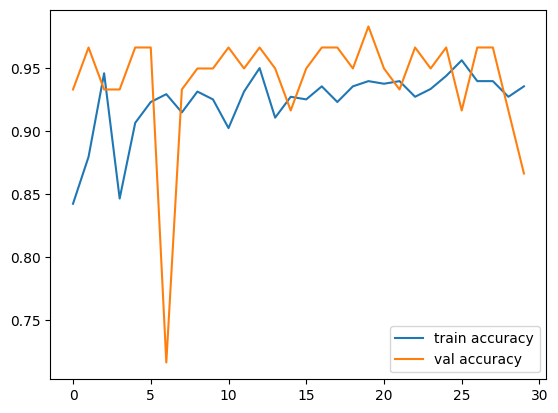

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = finetuned_model.fit(
    train_generator,
    epochs=100000,
    validation_data = val_generator,
    callbacks = [es],
    verbose=1,
)

sns.lineplot(history.history['accuracy'], label='train accuracy')
sns.lineplot(history.history['val_accuracy'], label='val accuracy')
plt.show()

#### 4) 성능 평가

In [ ]:
pred_y = finetuned_model.predict(test_generator)
pred_y = list(map(np.argmax,pred_y))

classification_report(pred_y, test_y)
accuracy_score(pred_y, test_y)

3/3 [==============================] - 0s 173ms/step


0.9354838709677419